# Varying Width Analysis

In [8]:

import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

In [9]:
def group_data_by_metric(directory):
    # Pattern looks for - or _ followed by digits then 'mm'
    metric_pattern = re.compile(r"[-_](\d+)mm", re.IGNORECASE)

    # Storage: {metric: [(distance_array, counts_array), ...]}
    grouped_data = {}
    # print(os.listdir(directory))

    for fname in os.listdir(directory):
        if not fname.endswith(".dat"):
            continue

        match = metric_pattern.search(fname)
        if not match:
            continue # Skip files that don't have the w-Xmm metric

        width = match.group(1)
        # print(width)

        # --- Your existing reading logic ---
        data = pd.read_csv(
            os.path.join(directory, fname),
            sep=r"\s+",
            skiprows=1,
            names=["Distance", "Counts"]
        )
        dist_array = data["Distance"].to_numpy()

        midpoint = (dist_array[-1] - dist_array[0])/2
        dist_array = dist_array - midpoint

        counts_array = data["Counts"].to_numpy()
        counts_uncertainty = count_uncertainty(counts_array)
        # -----------------------------------

        if width not in grouped_data:
            grouped_data[width] = []

        # Add a tuple of the two arrays to the list for this metric
        grouped_data[width].append((dist_array, counts_array, counts_uncertainty))

    return grouped_data

def count_uncertainty(count_arr):
    count_arr_uncertainty = []
    N = sum(count_arr)
    for count in count_arr:
        p_i = count / N
        uncertainty = np.sqrt(count * p_i * (1-p_i))
        count_arr_uncertainty.append(uncertainty)
    return count_arr_uncertainty


def plot(grouped_data, savename):
    plt.figure()
    plt.title("Sweeped Counts for Different Widths")
    plt.xlabel("Displacement (mm)")
    plt.ylabel("Counts")

    for metric in sorted(grouped_data.keys()):
        data_list = grouped_data[metric]

        # data_list is a list of tuples: (distance_array, counts_array)
        for dist, counts, ucounts in data_list:
            plt.errorbar(dist, counts, fmt='-o', yerr = ucounts, label=f"counts for width = {metric}mm")
            # plt.plot(dist, counts, label=f"counts for width = {metric}mm")

    plt.legend()
    plt.savefig(savename)
    plt.show()

def display_FWHM(grouped_fwhm):

    for width in sorted(grouped_fwhm.keys()):
        data_list = grouped_fwhm[width]

        # data_list is a list of tuples: (distance_array, counts_array)
        for fwhm, r0, r1 in data_list:
            print(f"with W={width}, fwhm={fwhm}mm, from {r0} to {r1}mm")



def normalize(grouped_data):
    for width in grouped_data:
        data_list = grouped_data[width]
        normalized_counts_list = []
        normalized_ucounts_list = []

        for dist, counts, ucounts in data_list:
            max_val = np.max(counts) # Use np.max for arrays
            maxvalIndex = np.where(counts == max_val)[0][0]
            max_uncertainty = ucounts[maxvalIndex]
            normalized_counts = counts / max_val
            for i,ucount in enumerate(ucounts):
                normalized_ucounts_list.append(normalized_counts[i] * np.sqrt( (ucount / counts[i])**2 + (max_uncertainty / max_val)**2))

            normalized_counts_list.append((dist, normalized_counts, normalized_ucounts_list))



        # Keep it as a list of tuples
        grouped_data[width] = normalized_counts_list

    return grouped_data

def getFWHM(normed_group_data):
    grouped_fwhm = {}

    for width in normed_group_data:
        data_list = normed_group_data[width]
        normalized_list = []

        for dist, counts, ucounts in data_list:
            fwhm, r0, r1 = get_fwhm(dist, counts)
            normalized_list.append((fwhm, r0, r1))

        # Keep it as a list of tuples
        grouped_fwhm[width] = normalized_list

    return grouped_fwhm

def get_fwhm(x, y):
    spline = UnivariateSpline(x, y - 0.5, s=0)
    # print(len(spline(x)))
    # plt.plot(x, spline(y))

    roots = spline.roots()

    if len(roots) >= 2:
        # Assuming the two outermost roots are the ones we want
        fwhm = abs(roots[-1] - roots[0])
        return fwhm, roots[0], roots[-1]
    return None, None, None

In [4]:

# Usage
WidthCalibrationJan14 = group_data_by_metric("./data/Width calibration - 2026-01-14")
# display(WidthCalibrationJan14)
WidthCalibrationJan14 = normalize(WidthCalibrationJan14)
# display(WidthCalibrationJan14)

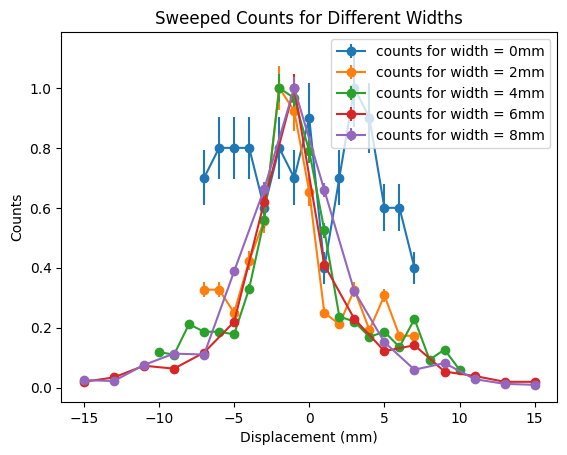

In [5]:
plot(WidthCalibrationJan14, "Width Calibration Jan14")

['Jan 16, 2026, 2_58 PM, Scan1, 0_0 Deg, w_8mm.dat', 'Jan 16, 2026, 2_22 PM, Scan1, 0_0 Deg, w_2mm.dat', 'Jan 16, 2026, 2_32 PM, Scan1, 0_0 Deg, w_4mm.dat', 'Jan 16, 2026, 2_43 PM, Scan1, 0_0 Deg, w_6mm.dat', 'Jan 19, 2026, 2_51 PM, Scan1, 0_0 Deg, 1_1mm.dat']
8
2
4
6
1


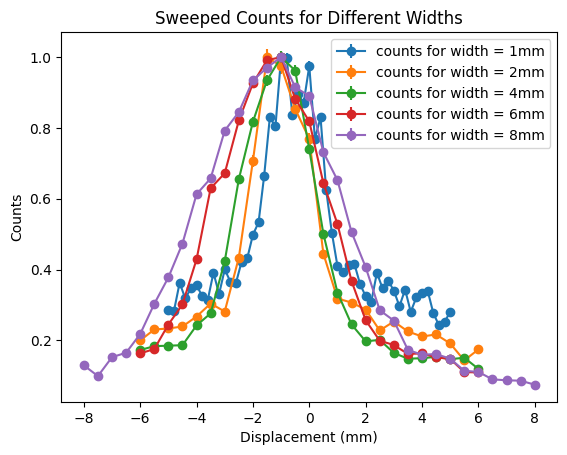

In [10]:
WidthCalibrationJan16 = group_data_by_metric("./data/Resolution Measurements - 2026-01-16")
WidthCalibrationJan16 = normalize(WidthCalibrationJan16)
plot(WidthCalibrationJan16, "Width Calibration Jan19")

In [11]:

grouped_FWHM = getFWHM(WidthCalibrationJan16)
display_FWHM(grouped_FWHM)

with W=1, fwhm=2.803622611370648mm, from -1.9935510926300841 to 0.8100715187405639mm
with W=2, fwhm=2.770339137500179mm, from -2.360247690450424 to 0.4100914470497548mm
with W=4, fwhm=3.3365970108295135mm, from -2.8333194603220178 to 0.5032775505074957mm
with W=6, fwhm=4.938379452950429mm, from -3.8378073023211785 to 1.1005721506292496mm
with W=8, fwhm=5.933490483685025mm, from -4.4099859252578275 to 1.5235045584271978mm


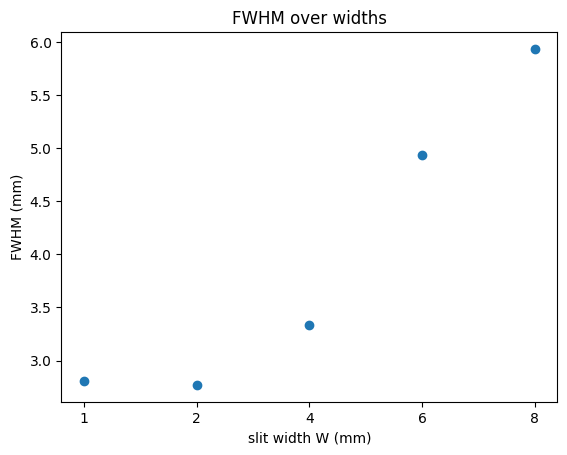

In [12]:

widths = []
fwhms = []
for width in sorted(grouped_FWHM.keys()):
    data_list = grouped_FWHM[width]

    # data_list is a list of tuples: (distance_array, counts_array)
    for fwhm, r0, r1 in data_list:
        # print(f"with W={width}, fwhm={fwhm}mm")
        # plt.scatter(width, fwhm)
        widths.append(width)
        fwhms.append(fwhm)

plt.figure()
plt.scatter(widths, fwhms)
plt.title("FWHM over widths")
plt.xlabel("slit width W (mm)")
plt.ylabel("FWHM (mm)")
plt.savefig("FWHM over slit width.png")
plt.show()


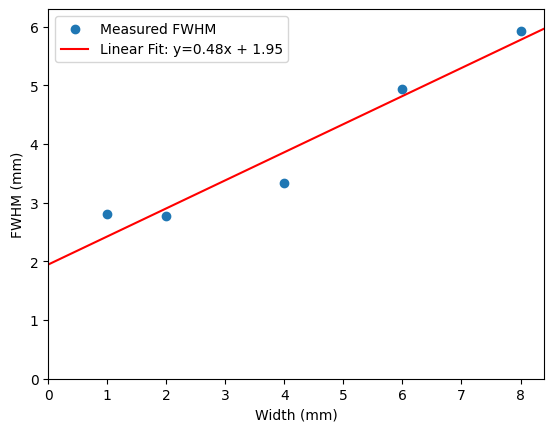

In [13]:
def linear_model(x, m, b):
    return m * x + b

widths_clean = np.array(widths, dtype=float)
fwhms_clean = np.array(fwhms, dtype=float)
# print(widths_clean)
# print(fwhms_clean)
# sorted_pairs = sorted(zip(widths_clean, fwhms_clean))
# x_sorted, y_sorted = zip(*sorted_pairs)
# print(x_sorted)
# print(y_sorted)
popt, pcov = curve_fit(linear_model, xdata=widths_clean, ydata=fwhms_clean)
m_opt, b_opt = popt
x_fit = np.linspace(0, 8.4, 100)
y_fit = linear_model(x_fit, m_opt, b_opt)

plt.figure()
plt.scatter(widths_clean, fwhms_clean, label="Measured FWHM")
plt.plot(x_fit, y_fit, 'r-', label=f"Linear Fit: y={m_opt:.2f}x + {b_opt:.2f}")

plt.xlabel("Width (mm)")
plt.ylabel("FWHM (mm)")
plt.xlim(0, 8.4)
plt.ylim(0, 6.3)
plt.legend()
plt.savefig("FWHM over widths with model.png")
plt.show()